# Analysis of in-situ radiography measurements - PART 2
Last update: 21.04.2025

# Aims
- Process in-situ test radiographs

# *Computational workflow*

## Part 1:
1. Load radiographs, flat fields and dark fields from in-situ test
2. Normalize
3. Background equalize
4. Save as separate .H5 file

## Imports and configuration

In [27]:
# default imports
import os
import dxchange
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt

In [28]:
# matplotlib plotting parameters
mpl.rcParams['figure.dpi'] = 300
mpl.rc('image', cmap='gray')
plt.style.use('ggplot')

mpl.style.use("dark_background")
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["image.interpolation"] = "bicubic"
mpl.rcParams["image.cmap"] = "Greys_r"
mpl.rcParams["figure.figsize"] = (8,6)

### Function definition

In [29]:
def normalize(im, flat, dark):
    im = im.astype('float32')
    flat = np.median(flat, axis=0).astype('float32')
    dark = np.median(dark, axis=0).astype('float32')

    return (im - dark) / (flat - dark)

## Load in-situ radiography experiment data
- On `PETRA`:

In [30]:
sample_name = "palm_leaf_tensile_11_far-20240926T135239"
work_dir = os.path.join("/", "PETRA", "SED", "BEATS", "IH", "2024", "palm_leaf")

h5file = os.path.join(work_dir, sample_name, f'{sample_name}.h5')

flats_file = "palm_leaf_tensile_11_far_FLAT_DARK-20240926T141726"
h5file_flats = os.path.join(work_dir, flats_file, f'{flats_file}.h5')

results_dir = '/PETRA/SED/BEATS/IH/scratch/palm_leaf/in-situ_radiography/'

## Load portions of FLATS and DARKS .H5 file
Slicing parameters:
- > slc_1500 = ((3700, 6700, 2), (482, 2100, 1), (500, 1950, 1))

- From projection 3700 to 6700 in steps of 2
- Crop X: 482 : 2100
- Crop Y: 500 : 1950

- > slc_flats = ((0, 101, 1), (482, 2100, 1), (500, 1950, 1))

- From flat 0 to 101
- Crop X: 482 : 2100 (same crop as for the radiographs!)
- Crop Y: 500 : 1950 (same crop as for the radiographs!)


In [31]:
slc_1500 = ((3700, 6700, 2), (482, 2100, 1), (500, 1950, 1))
slc_flats = ((0, 101, 1), (482, 2100, 1), (500, 1950, 1))

In [33]:
# read the entire flat field series
# _, flats, _, _ = dxchange.read_sesame_beats(h5file_flats, exchange_rank=0)

In [32]:
# read a portion of the flat field file
flats = dxchange.reader.read_hdf5(h5file_flats, '/exchange/data_white', slc=slc_flats, dtype=None, shared=False)

INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/palm_leaf/palm_leaf_tensile_11_far_FLAT_DARK-20240926T141726/palm_leaf_tensile_11_far_FLAT_DARK-20240926T141726.h5


In [34]:
# read the entire flat field series
# _, _, darks, _ = dxchange.read_sesame_beats(h5file_flats, exchange_rank=0)

In [35]:
# read a portion of the dark field file
darks = dxchange.reader.read_hdf5(h5file_flats, '/exchange/data_dark', slc=slc_flats, dtype=None, shared=False)

INFO:dxchange.reader:Data successfully imported: /PETRA/SED/BEATS/IH/2024/palm_leaf/palm_leaf_tensile_11_far_FLAT_DARK-20240926T141726/palm_leaf_tensile_11_far_FLAT_DARK-20240926T141726.h5


In [36]:
print("Flat fields size: ", flats[:, :, :].shape[:])
print("Dark fields size: ", darks[:, :, :].shape[:])

Flat fields size:  (101, 1618, 1450)
Dark fields size:  (101, 1618, 1450)


Text(0.5, 1.0, 'darks')

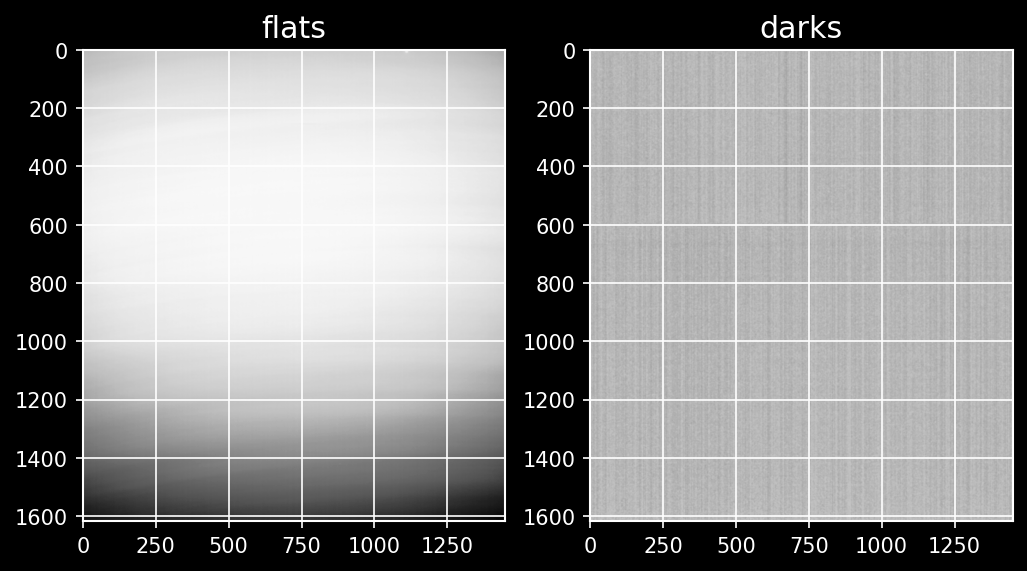

In [37]:
plt.subplot(1, 2, 1)
plt.imshow(np.median(flats, axis=0))
# plt.colorbar()
plt.title('flats')
plt.subplot(1, 2, 2)
plt.imshow(np.median(darks, axis=0))
# plt.colorbar()
plt.title('darks')

### Load radiographs
> The radiographs were collected as flat fields so they are located in the `/exchange/data_white` position of the `.h5` file

- From projection 3700 to 6700 in steps of 2
- Crop X: 482 : 2100
- Crop Y: 500 : 1950

In [38]:
# read the entire dataset (170 GB !!)
# _, projs, _, _ = dxchange.read_sesame_beats(h5file, exchange_rank=0)

In [ ]:
# read a portion of the radiographs
projs = dxchange.reader.read_hdf5(h5file, '/exchange/data_white', slc=slc_1500, dtype=None, shared=False)

In [39]:
print("Dataset size: ", projs[:, :, :].shape[:], " - dtype: ", projs.dtype)

Dataset size:  (1500, 1618, 1450)  - dtype:  float32


## Flat field correction
Normalize the image background.

In [ ]:
projs = tomopy.normalize(projs, flats, darks, ncore=ncore, averaging='median')

Text(0.5, 1.0, 'darks')

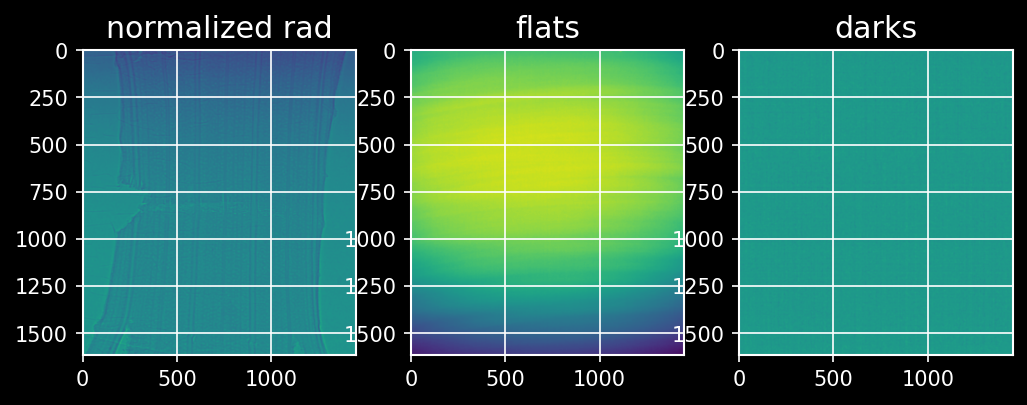

In [40]:
plt.subplot(1, 3, 1)
plt.imshow(projs[0,:,:], cmap='viridis')
# plt.colorbar()
plt.title('normalized rad')
plt.subplot(1, 3, 2)
plt.imshow(flats[0,:,:], cmap='viridis')
# plt.colorbar()
plt.title('flats')
plt.subplot(1, 3, 3)
plt.imshow(darks[0,:,:], cmap='viridis')
# plt.colorbar()
plt.title('darks')

## Equalize background
Still partial inhomogeneity after flat field-correction

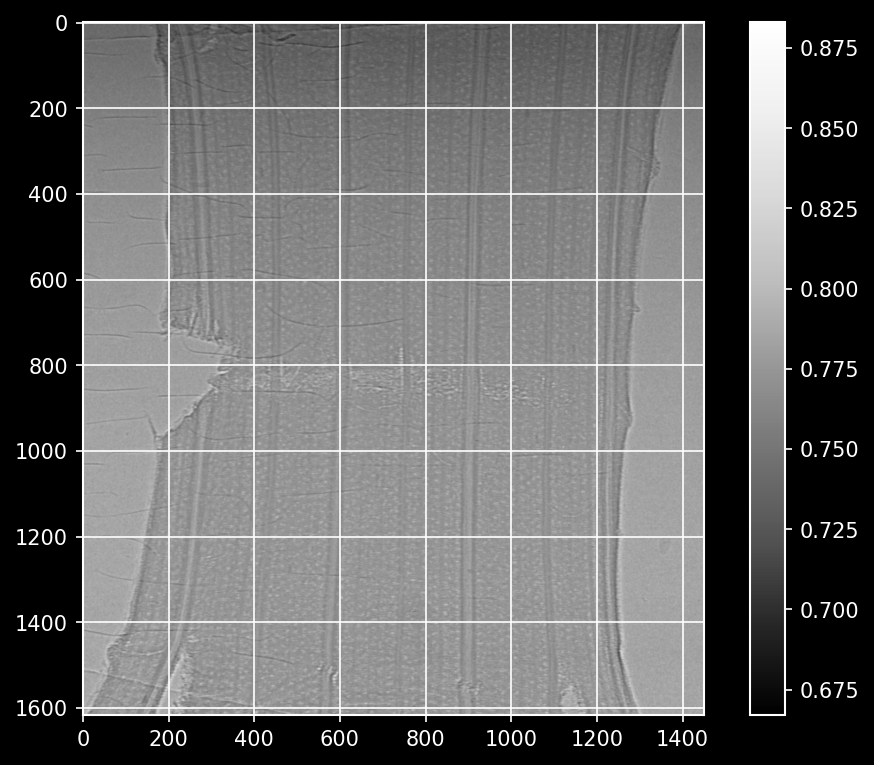

In [41]:
plt.imshow(projs[5,:,:])
plt.colorbar()

In [42]:
background_mean = np.mean(projs, axis=(0,2))
background_X = np.arange(0, len(background_mean), 1)

In [43]:
# Fit a polynomial of degree X
degree = 3
coefficients = np.polyfit(background_X, background_mean, degree)

# Create a polynomial function from the coefficients
polynomial = np.poly1d(coefficients)

# Generate y-values from the polynomial
background_fit = polynomial(background_X)


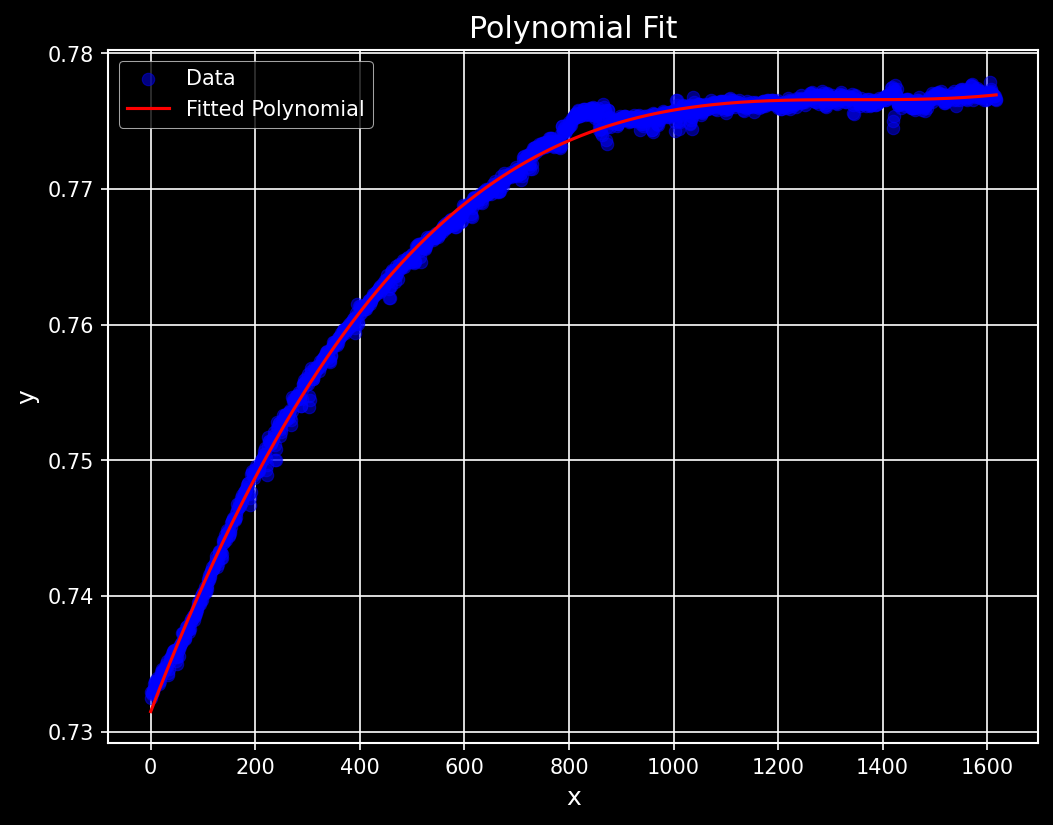

In [44]:
# Plot the original data and the fitted polynomial
plt.scatter(background_X, background_mean, label='Data', color='blue', alpha=0.5)
plt.plot(background_X, background_fit, label='Fitted Polynomial', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Fit')
plt.legend()
plt.show()

### Tile the fit to create an equalization mask

In [45]:
background_mask = np.swapaxes(np.tile(background_fit, (projs.shape[0], projs.shape[2], 1)), 1, 2)
print(background_mask.shape)
print(projs.shape)
print(projs.dtype)

(1500, 1618, 1450)
(1500, 1618, 1450)
float32


In [46]:
projs_eq = projs / background_mask

Text(0.5, 1.0, 'normalized; equalized')

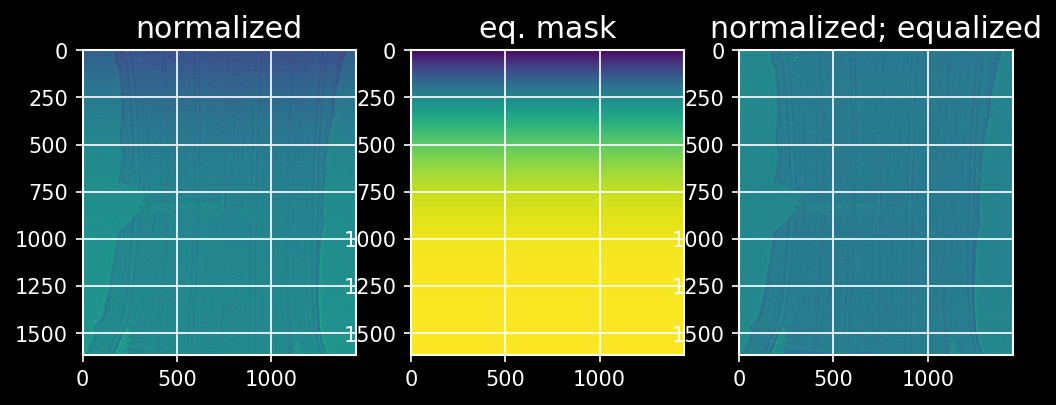

In [47]:
plt.subplot(1, 3, 1)
plt.imshow(projs[0,:,:], cmap='viridis')
# plt.colorbar()
plt.title('normalized')
plt.subplot(1, 3, 2)
plt.imshow(background_mask[0,:,:], cmap='viridis')
# plt.colorbar()
plt.title('eq. mask')
plt.subplot(1, 3, 3)
plt.imshow(projs_eq[0,:,:], cmap='viridis')
# plt.colorbar()
plt.title('normalized; equalized')

### Save normalized frames as a stack of `.TIFF` images

In [ ]:
processed_tiff_name = 'averaged_and_normalized_and_equalized'
processed_tiff_stack = os.path.join(results_dir, processed_tiff_name, f'step.tiff')

In [ ]:
dxchange.writer.write_tiff_stack(projs_eq, processed_tiff_stack, digit=4, axis=0, start=0, overwrite=True)